# Outcome Prediction (Node Classification) with TransE Model + MLP

In [22]:
import os
import joblib

import numpy as np
import pandas as pd

from pykeen.triples import TriplesFactory
from pykeen.predict import predict_target
from pykeen.pipeline import pipeline

## 1. Load KG and remove outcomes

In [2]:
dataset = 'syn_data_graph.xml'
def preprocess(data_name):
    s_list, r_list, d_list = [], [], []
    
    with open(data_name) as f:
        s = next(f)
        print(s)
        for idx, line in enumerate(f):
            e = line.strip().split('\t')
            s = e[0]
            r = e[1]
            d = e[2]            
            
            s_list.append(s)
            r_list.append(r)
            d_list.append(d)            
            
    return pd.DataFrame({
        's':s_list, 
        'r':r_list, 
        'd':d_list,                          
        })

df = preprocess(dataset)
print(df.head())

P0	hasOutput	Reabilitation

                        s              r                   d
0           Reabilitation         output                  P0
1           Reabilitation       rdf:type              output
2                      P0       rdf:type             patient
3  hospital_stay_length_0  value_feature                  P0
4  hospital_stay_length_0       hasValue  27.408750107649045


### Remove outcomes from KG

In [3]:
outcome = df['d'].str.contains('Reabilitation|Back2Home|Death')
node_df = df[~outcome]
node_df = node_df.reset_index(drop=True)
outcome = node_df['s'].str.contains('Reabilitation|Back2Home|Death')
node_df = node_df[~outcome]
node_df = node_df.reset_index(drop=True)

In [4]:
print(node_df.head())

                        s              r                     d
0                      P0       rdf:type               patient
1  hospital_stay_length_0  value_feature                    P0
2  hospital_stay_length_0       hasValue    27.408750107649045
3  hospital_stay_length_0       rdf:type  hospital_stay_length
4                   gcs_0  value_feature                    P0


In [5]:
ent_to_id = {k: v for v, k in enumerate(set(node_df['s']).union(set(node_df['d'])), start=0)}
rel_to_id = {k: v for v, k in enumerate(set(node_df['r']), start=0)}

patients = [f"P{i}" for i in range(10000)]
patient_id = []
for patient in patients:
    patient_id.append(ent_to_id[patient])

num_nodes = max(ent_to_id.values()) + 1
num_rels = max(rel_to_id.values()) + 1

events = node_df.copy()
events["s"] = node_df.s.map(ent_to_id)
events["d"] = node_df.d.map(ent_to_id)
events["r"] = node_df.r.map(rel_to_id)

ent_to_id = pd.DataFrame.from_dict(ent_to_id, orient='index')
rel_to_id = pd.DataFrame.from_dict(rel_to_id, orient='index')

### Save events, entities and relations to 'processed_data' folder

In [6]:
path = 'processed_data'
if not os.path.exists(path):
    os.makedirs(path)

events.to_csv(f'{path}/sphn_events_noOutcome.tsv', sep='\t', index=False, header=None)
ent_to_id.to_csv(f'{path}/sphn_entities_noOutcome.tsv', sep='\t', header=None)
rel_to_id.to_csv(f'{path}/sphn_relations_noOutcome.tsv', sep='\t', header=None)

## 2. Training the model

In [8]:
tf = TriplesFactory.from_path(f'{path}/sphn_events_noOutcome.tsv', create_inverse_triples=False)

No random seed is specified. Setting to 1288951414.


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/407k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1183.17s seconds


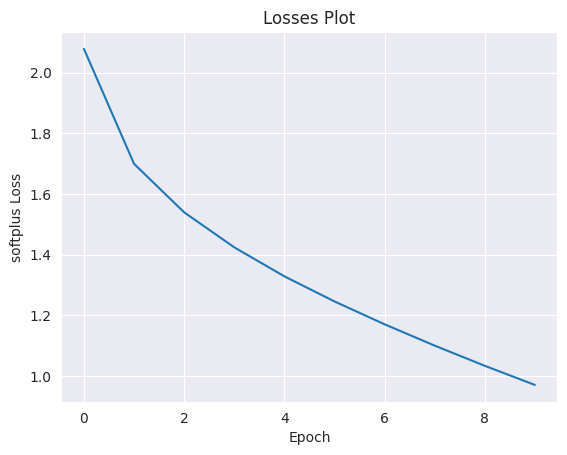

In [10]:
model_name = 'TransE'
embedding_dim = 16
epochs = 10

result = pipeline(
    training=tf,
    testing=tf,
    model=model_name,
    model_kwargs=dict(
        embedding_dim=embedding_dim,
        loss="softplus",
    ),
    training_kwargs=dict(
        num_epochs=epochs,
        use_tqdm_batch=False,
    ),
    optimizer_kwargs=dict(
        lr=0.001,
        weight_decay=1e-5,
    ),
    training_loop='sLCWA',
    negative_sampler='basic',
    device='gpu',
    use_tqdm=True,
)

#plot loss
loss_plot = result.plot_losses()

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = result.model
entity_embedding = model.entity_representations[0](indices=None).detach().cpu()
patient_embedding = entity_embedding[patient_id]
print(patient_embedding.shape)

patient_embedding = patient_embedding.to(device)
y = joblib.load('ouput.joblib')
y = torch.Tensor(y).long().to(device)

train_x, train_y = patient_embedding[:8000], y[:8000]
val_x, val_y = patient_embedding[8000:9000], y[8000:9000]
test_x, test_y = patient_embedding[9000:], y[9000:]

torch.Size([10000, 16])


In [40]:
# MLP classifier
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return F.log_softmax(x, dim=1)
    
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_x)
    loss = F.nll_loss(out, train_y)
    loss.backward()
    optimizer.step()
    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_output = model(val_x)
        val_loss = F.nll_loss(val_output, val_y)
    return float(loss), float(val_loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(patient_embedding).argmax(dim=-1)
    train_acc = float((pred[:8000] == train_y).float().mean())
    val_acc = float((pred[8000:9000] == val_y).float().mean())
    test_acc = float((pred[9000:] == test_y).float().mean())
    return train_acc, val_acc, test_acc

import time

times = []
best_loss = float('inf')

for epoch in range(1, 1001):
    start = time.time()
    loss, val_loss = train()
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 10  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping...")
            break
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val_Loss: {val_loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f} '
        f'Test: {test_acc:.4f}')
        
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Loss: 1.1842, Val_Loss: 1.1670, Train: 0.1258, Val: 0.1280 Test: 0.1200
Epoch: 02, Loss: 1.1656, Val_Loss: 1.1499, Train: 0.1274, Val: 0.1300 Test: 0.1220
Epoch: 03, Loss: 1.1483, Val_Loss: 1.1342, Train: 0.1584, Val: 0.1530 Test: 0.1460
Epoch: 04, Loss: 1.1322, Val_Loss: 1.1195, Train: 0.2344, Val: 0.2270 Test: 0.2310
Epoch: 05, Loss: 1.1171, Val_Loss: 1.1058, Train: 0.3178, Val: 0.3110 Test: 0.3020
Epoch: 06, Loss: 1.1030, Val_Loss: 1.0930, Train: 0.3746, Val: 0.3600 Test: 0.3660
Epoch: 07, Loss: 1.0897, Val_Loss: 1.0810, Train: 0.4156, Val: 0.4030 Test: 0.4200
Epoch: 08, Loss: 1.0771, Val_Loss: 1.0697, Train: 0.4308, Val: 0.4340 Test: 0.4410
Epoch: 09, Loss: 1.0653, Val_Loss: 1.0592, Train: 0.4368, Val: 0.4410 Test: 0.4410
Epoch: 10, Loss: 1.0542, Val_Loss: 1.0495, Train: 0.4403, Val: 0.4390 Test: 0.4440
Epoch: 11, Loss: 1.0440, Val_Loss: 1.0406, Train: 0.4420, Val: 0.4420 Test: 0.4460
Epoch: 12, Loss: 1.0345, Val_Loss: 1.0326, Train: 0.4426, Val: 0.4410 Test: 0.4450
Epoc